In [28]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [29]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import glob
import matplotlib.image as mpimg

In [30]:
# ----------------------------------------------------------
# Device
# ----------------------------------------------------------
device = torch.device("mps" if torch.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f'Using Device {device}')


Using Device mps


In [14]:
# ----------------------------------------------------------
# Hyperparameters (Variant of SAGAN without SN + TTUR)
# ----------------------------------------------------------
EPOCHS = 550
BATCH_SIZE = 128
IMAGE_SIZE = 32
CHANNELS_IMG = 3
LATENT_DIM = 128
EMBED_DIM = 50
GEN_LR = 1e-4
DISC_LR = 4e-4
BETA1, BETA2 = 0.0, 0.9
CHECKPOINT_EVERY = 20
AUTOMOBILE_CLASS_IDX = 1

In [15]:
# ----------------------------------------------------------
# Self-Attention Block
# ----------------------------------------------------------
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.size()
        query_out = self.query(x).view(b, -1, w*h)             # (b, c//8, h*w)
        key_out   = self.key(x).view(b, -1, w*h)               # (b, c//8, h*w)
        attn      = torch.bmm(query_out.permute(0, 2, 1), key_out)  # (b, h*w, h*w)
        attn      = torch.softmax(attn, dim=-1)
        value_out = self.value(x).view(b, c, w*h)              # (b, c, h*w)
        out       = torch.bmm(value_out, attn.permute(0, 2, 1)) # (b, c, h*w)
        out       = out.view(b, c, h, w)
        return self.gamma * out + x

In [16]:
# ----------------------------------------------------------
# CIFAR-10 Data Loading
# ----------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
automobile_indices = [i for i, (_, label) in enumerate(trainset) if label == AUTOMOBILE_CLASS_IDX]
automobile_dataset = Subset(trainset, automobile_indices)
trainloader = DataLoader(automobile_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [17]:
# ----------------------------------------------------------
# Generator (SAGAN-style, no SN)
# ----------------------------------------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, embed_dim, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        self.init_fc = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 4*4*512),
            nn.BatchNorm1d(4*4*512),
            nn.ReLU(True)
        )
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Self-Attention in the 16x16 feature map
            SelfAttention(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, CHANNELS_IMG, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        emb = self.label_emb(labels)
        x = torch.cat([z, emb], dim=1)
        x = self.init_fc(x).view(-1, 512, 4, 4)
        return self.conv_blocks(x)

In [18]:
# ----------------------------------------------------------
# Discriminator (SAGAN-style, no SN)
# ----------------------------------------------------------
class Discriminator(nn.Module):
    def __init__(self, embed_dim, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(CHANNELS_IMG, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # Self-Attention in the 16x16 feature map
            SelfAttention(128),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(512*2*2 + embed_dim, 1)

    def forward(self, x, labels):
        bsz = x.size(0)
        emb = self.label_emb(labels)
        features = self.conv_blocks(x).view(bsz, -1)
        combined = torch.cat([features, emb], dim=1)
        return self.fc(combined)


In [19]:
# ----------------------------------------------------------
# Initialize Model, Loss, Optimizers (TTUR)
# ----------------------------------------------------------
gen = Generator(LATENT_DIM, EMBED_DIM).to(device)
disc = Discriminator(EMBED_DIM).to(device)
criterion = nn.BCEWithLogitsLoss()

opt_gen = optim.Adam(gen.parameters(), lr=GEN_LR, betas=(BETA1, BETA2))
opt_disc = optim.Adam(disc.parameters(), lr=DISC_LR, betas=(BETA1, BETA2))

checkpoint_path = "adl_part_3.pt"
start_epoch = 1

In [20]:
# ----------------------------------------------------------
# Check for Existing Checkpoint
# ----------------------------------------------------------
if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    gen.load_state_dict(ckpt["gen_state_dict"])
    disc.load_state_dict(ckpt["disc_state_dict"])
    opt_gen.load_state_dict(ckpt["opt_gen_state_dict"])
    opt_disc.load_state_dict(ckpt["opt_disc_state_dict"])
    start_epoch = ckpt["epoch"] + 1

In [21]:
# ----------------------------------------------------------
# Utility: Generate & Show Samples
# ----------------------------------------------------------
def generate_and_show_samples(epoch):
    gen.eval()
    with torch.no_grad():
        z = torch.randn(10, LATENT_DIM, device=device)
        labels = torch.full((10,), AUTOMOBILE_CLASS_IDX, dtype=torch.long, device=device)
        samples = gen(z, labels).cpu()
    samples = (samples + 1) / 2.0
    fig, axes = plt.subplots(1, 10, figsize=(22, 2.4))
    for i in range(10):
        img = samples[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(f"Epoch {epoch}: SAGAN-Variant Samples (Automobile)", fontsize=14)
    plt.savefig(f'task3/automobile_gan_losses_{epoch}.png')
    plt.show()
    gen.train()

In [22]:
# ----------------------------------------------------------
# Compute IS & FID
# ----------------------------------------------------------
def compute_is_fid(generator, loader, n_samples=2000):
    is_metric = InceptionScore().to("cpu")
    fid_metric = FrechetInceptionDistance().to("cpu")
    generator.eval()

    real_count = 0
    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        real_imgs_uint8 = (((real_imgs * 0.5) + 0.5) * 255).to(torch.uint8).cpu()
        fid_metric.update(real_imgs_uint8, real=True)
        real_count += real_imgs.size(0)
        if real_count >= n_samples:
            break

    fake_count = 0
    while fake_count < n_samples:
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (BATCH_SIZE,), dtype=torch.long, device=device)
        with torch.no_grad():
            fake_out = generator(z, labels)
        fake_out_uint8 = (((fake_out * 0.5) + 0.5) * 255).to(torch.uint8).cpu()
        is_metric.update(fake_out_uint8)
        fid_metric.update(fake_out_uint8, real=False)
        fake_count += BATCH_SIZE

    inception_score = is_metric.compute()  # (mean, std)
    fid_score = fid_metric.compute()
    generator.train()
    return inception_score[0].item(), fid_score.item()

[Epoch 501/550]  LossD: 0.0084  LossG: 30.5150
[Epoch 502/550]  LossD: 0.0000  LossG: 26.5804
[Epoch 503/550]  LossD: 0.0515  LossG: 17.1791
[Epoch 504/550]  LossD: 0.0021  LossG: 41.7324
[Epoch 505/550]  LossD: 0.0000  LossG: 28.7694
[Epoch 506/550]  LossD: 0.0006  LossG: 33.8097
[Epoch 507/550]  LossD: 0.0705  LossG: 35.9834
[Epoch 508/550]  LossD: 0.0033  LossG: 22.5316
[Epoch 509/550]  LossD: 0.0017  LossG: 41.0436
[Epoch 510/550]  LossD: 0.0824  LossG: 29.4740
[Epoch 511/550]  LossD: 1.8864  LossG: 20.3700
[Epoch 512/550]  LossD: 0.0001  LossG: 55.0313
[Epoch 513/550]  LossD: 0.0020  LossG: 50.0931
[Epoch 514/550]  LossD: 0.0071  LossG: 29.5711
[Epoch 515/550]  LossD: 0.0000  LossG: 47.5927
[Epoch 516/550]  LossD: 0.0000  LossG: 37.7736
[Epoch 517/550]  LossD: 0.0172  LossG: 12.9776
[Epoch 518/550]  LossD: 0.0001  LossG: 65.8510
[Epoch 519/550]  LossD: 0.0016  LossG: 16.5696
[Epoch 520/550]  LossD: 0.0647  LossG: 55.0012
[epoch=520]Checkpoint saved: adl_part_3.pt


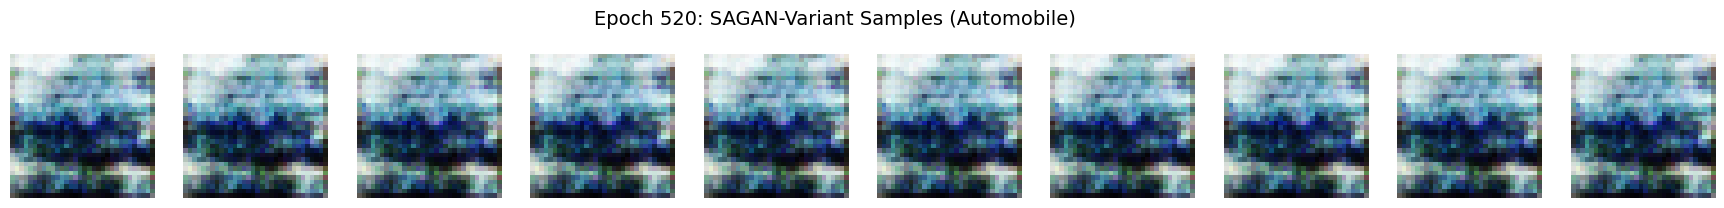

/Users/shivamsahil/Downloads/bits/assignments/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


==> Epoch 520: Inception Score = 1.3875, FID = 315.2394
[Epoch 521/550]  LossD: 0.0049  LossG: 35.1182
[Epoch 522/550]  LossD: 0.0000  LossG: 54.1443
[Epoch 523/550]  LossD: 0.0015  LossG: 37.0467
[Epoch 524/550]  LossD: 0.0001  LossG: 53.0654
[Epoch 525/550]  LossD: 0.0000  LossG: 50.4639
[Epoch 526/550]  LossD: 0.0003  LossG: 49.2188
[Epoch 527/550]  LossD: 0.0005  LossG: 43.3066
[Epoch 528/550]  LossD: 0.0833  LossG: 23.3325
[Epoch 529/550]  LossD: 0.0024  LossG: 56.1662
[Epoch 530/550]  LossD: 0.0004  LossG: 43.3856
[Epoch 531/550]  LossD: 0.0001  LossG: 69.2146
[Epoch 532/550]  LossD: 0.0122  LossG: 28.4343
[Epoch 533/550]  LossD: 0.0000  LossG: 54.0010
[Epoch 534/550]  LossD: 0.4353  LossG: 45.7758
[Epoch 535/550]  LossD: 0.0683  LossG: 62.5474
[Epoch 536/550]  LossD: 0.7499  LossG: 92.6146
[Epoch 537/550]  LossD: 0.0002  LossG: 46.4222
[Epoch 538/550]  LossD: 0.0801  LossG: 44.5221
[Epoch 539/550]  LossD: 0.0000  LossG: 26.9270
[Epoch 540/550]  LossD: 0.0000  LossG: 57.2657
[epo

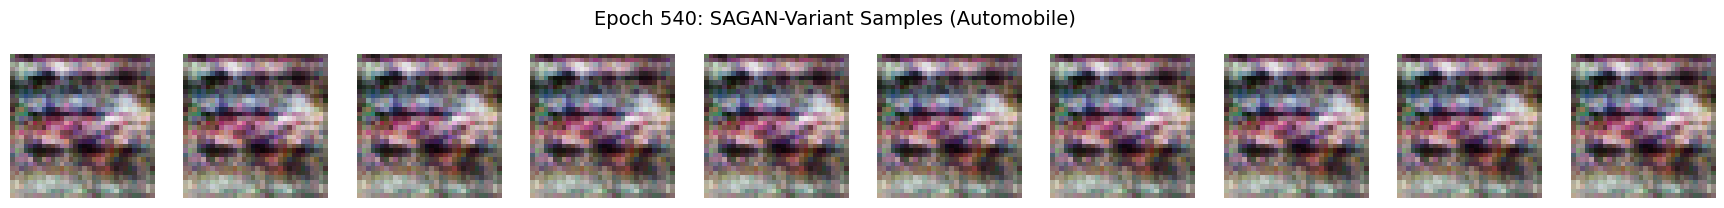

==> Epoch 540: Inception Score = 1.7105, FID = 339.5601
[Epoch 541/550]  LossD: 0.0017  LossG: 32.2723
[Epoch 542/550]  LossD: 0.0193  LossG: 47.9374
[Epoch 543/550]  LossD: 0.0074  LossG: 33.3457
[Epoch 544/550]  LossD: 0.0010  LossG: 52.6690
[Epoch 545/550]  LossD: 0.0003  LossG: 24.1623
[Epoch 546/550]  LossD: 0.0000  LossG: 58.0807
[Epoch 547/550]  LossD: 0.0000  LossG: 35.8908
[Epoch 548/550]  LossD: 0.0000  LossG: 38.9137
[Epoch 549/550]  LossD: 0.0001  LossG: 61.0286
[Epoch 550/550]  LossD: 0.0196  LossG: 30.3804
Training complete!


In [23]:
# ----------------------------------------------------------
# Training Loop
# ----------------------------------------------------------
for epoch in range(start_epoch, EPOCHS + 1):
    for _, (real, labels) in enumerate(trainloader):
        real, labels = real.to(device), labels.to(device)
        bsz = real.size(0)

        # --------------------
        # Train Discriminator
        # --------------------
        disc.zero_grad()
        noise = torch.randn(bsz, LATENT_DIM, device=device)
        rand_labels = torch.randint(0, 10, (bsz,), dtype=torch.long, device=device)

        pred_real = disc(real, labels)
        loss_real = criterion(pred_real, torch.ones_like(pred_real))

        fake = gen(noise, rand_labels)
        pred_fake = disc(fake.detach(), rand_labels)
        loss_fake = criterion(pred_fake, torch.zeros_like(pred_fake))

        lossD = loss_real + loss_fake
        lossD.backward()
        opt_disc.step()

        # ----------------
        # Train Generator
        # ----------------
        gen.zero_grad()
        pred_gen = disc(fake, rand_labels)
        lossG = criterion(pred_gen, torch.ones_like(pred_gen))
        lossG.backward()
        opt_gen.step()

    print(f"[Epoch {epoch}/{EPOCHS}]  LossD: {lossD.item():.4f}  LossG: {lossG.item():.4f}")

    if epoch % CHECKPOINT_EVERY == 0:
        save_data = {
            "epoch": epoch,
            "gen_state_dict": gen.state_dict(),
            "disc_state_dict": disc.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_disc_state_dict": opt_disc.state_dict()
        }
        torch.save(save_data, checkpoint_path)
        print(f"[epoch={epoch}]Checkpoint saved: {checkpoint_path}")
        generate_and_show_samples(epoch)
        is_val, fid_val = compute_is_fid(gen, trainloader)
        print(f"==> Epoch {epoch}: Inception Score = {is_val:.4f}, FID = {fid_val:.4f}")

print("Training complete!")


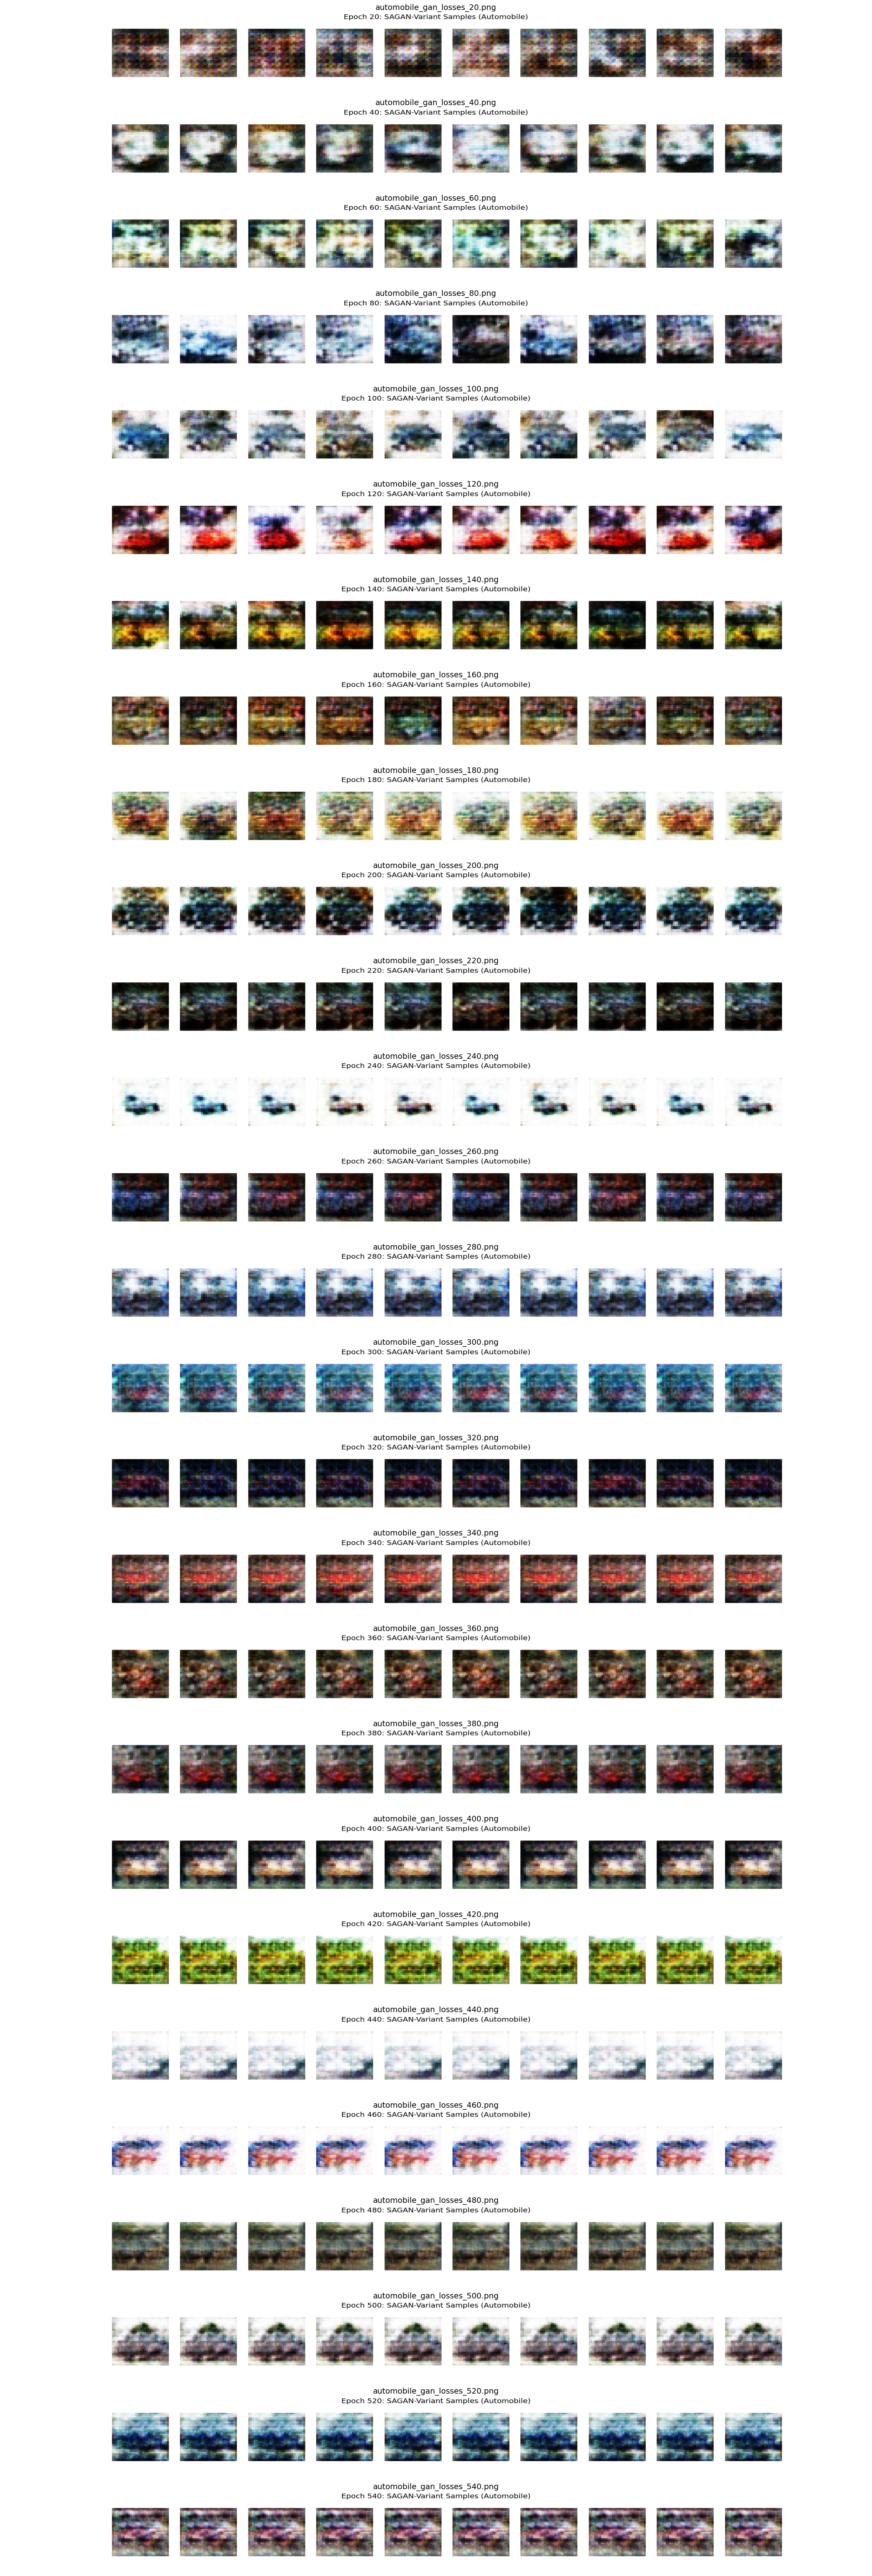

In [32]:
directory = r'task3'
# Define a custom sort key that extracts the epoch number
def extract_epoch(filename):
    base = os.path.basename(filename)
    try:
        # Assuming filename format: automobile_gan_losses_{epoch_number}.png
        epoch_str = base.split('automobile_gan_losses_')[1].split('.')[0]
        return int(epoch_str)
    except (IndexError, ValueError):
        return float('inf')  # Place any files that don't match the pattern at the end
png_files = glob.glob(os.path.join(directory, '*.png'))
# Sort the list numerically by epoch number
png_files = sorted(png_files, key=extract_epoch)

# Check if any PNG files are found
if not png_files:
    print("No PNG files found in the directory:", directory)
else:
    n = len(png_files)
    
    # Increase the figure size to accommodate full screen-like display
    fig, axs = plt.subplots(n, 1, figsize=(22, 2.4 * n))
    
    # If only one image, wrap axs into a list for consistency
    if n == 1:
        axs = [axs]

    # Attempt to maximize the figure window (works on some backends)
    mng = plt.get_current_fig_manager()
    try:
        # This works for some backends (e.g., TkAgg on Windows)
        mng.window.state('zoomed')
    except AttributeError:
        try:
            # Alternative for other backends (e.g., Qt)
            mng.window.showMaximized()
        except Exception:
            pass  # If it fails, the figure will remain at the set figsize

    # Loop through each file and display the image
    for ax, file in zip(axs, png_files):
        img = mpimg.imread(file)
        ax.imshow(img, aspect='auto')
        ax.axis('off')
        ax.set_title(os.path.basename(file), fontsize=14)
    
    plt.tight_layout()
    plt.show()